# Custom Nucleation: Single Species

In this *How-to Guide*, we will demonstrate how to create a custom nucleation model for a single-species aerosol system. We will use fixed nucleation rates for demonstration purposes. This approach highlights the flexibility of adding new processes to your aerosol simulation before full integration into the main codebase.

This guide is based on the **Dynamics Customization** tutorial.

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.next import particles, dynamics
from particula.next.aerosol import Aerosol

# Gas phase species and atmosphere builders
from particula.next.gas.species_builders import GasSpeciesBuilder
from particula.next.gas.atmosphere_builders import AtmosphereBuilder

# Vapor pressure factory for calculating vapor pressures
from particula.next.gas.vapor_pressure_factories import VaporPressureFactory

## Aerosol Setup

We will begin by setting up ammonium sulfate (SO₄) vapor alongside a few pre-existing particles. The vapor phase will include a constant vapor pressure for ammonium sulfate, and a lognormal distribution will be used to represent the initial particle population.

The pre-existing particles are also necessary as, the zero particle case is not supported in the current version of the model.

In [2]:
# Build the sulfate gas species

# Ammonium sulfate properties
molar_mass_ammonium_sulfate = 132.14e-3  # kg/mol
density_ammonium_sulfate = 1.77e3  # kg/m^3

# Define vapor pressure parameters for ammonium sulfate
parameters_vapor = {
    "vapor_pressure": 4e-12,  # pascal
    "vapor_pressure_units": "atm",  # units
}

# Create a constant vapor pressure strategy using the VaporPressureFactory
vapor_pressure_sulfate = VaporPressureFactory().get_strategy(
    "constant", parameters_vapor
)

# Calculate the saturation concentration at a given temperature
sulfate_saturation = vapor_pressure_sulfate.saturation_concentration(
    molar_mass=molar_mass_ammonium_sulfate,
    temperature=298.15,  # Kelvin
)

# Set initial sulfate concentration as a fraction of saturation concentration
initial_sulfate_concentration = 0.5 * sulfate_saturation  # kg/m^3

# Build the sulfate gas species using the GasSpeciesBuilder
gas_sulfate = (
    GasSpeciesBuilder()
    .set_name("sulfate")
    .set_molar_mass(molar_mass_ammonium_sulfate, "kg/mol")
    .set_condensable(True)
    .set_vapor_pressure_strategy(vapor_pressure_sulfate)
    .set_concentration(initial_sulfate_concentration, "kg/m^3")
    .build()
)

# Build the atmosphere with the sulfate species and environmental conditions
atmosphere = (
    AtmosphereBuilder()
    .add_species(gas_sulfate)  # Add sulfate to the atmosphere
    .set_temperature(25, temperature_units="degC")  # Set temperature to 25°C
    .set_pressure(1, pressure_units="atm")  # Set pressure to 1 atm
    .build()
)

# Generate a lognormal particle size distribution
particle_sample = particles.properties.lognormal_sample_distribution(
    mode=np.array([400e-9]),  # Mean particle diameter of 400 nm
    geometric_standard_deviation=np.array([1.4]),  # GSD of 1.4
    number_of_particles=np.array(
        [1e4]
    ),  # Number of particles in the distribution
    number_of_samples=100,  # Number of particle samples
)

# Calculate the mass of each particle based on its size and ammonium sulfate density
particle_mass_sample = (
    4 / 3 * np.pi * particle_sample**3 * density_ammonium_sulfate  # kg
)

# Build the resolved particle mass representation for the aerosol particles
resolved_masses = (
    particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(particles.ActivityIdealMass())
    .set_surface_strategy(particles.SurfaceStrategyVolume())
    .set_mass(particle_mass_sample, "kg")
    .set_density(density_ammonium_sulfate, "kg/m^3")
    .set_charge(0)
    .set_volume(0.1, "cm^3")
    .build()
)

# Create the aerosol object with the atmosphere and particles
aerosol = Aerosol(atmosphere=atmosphere, particles=resolved_masses)

# Print the properties of the created aerosol system
print(aerosol)

Gas mixture at 298.15 K and 101325.0 Pa consisting of ['sulfate']
[0]: Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 9.623e-07 [kg/m^3]
	Number Concentration: 1.000e+09 [#/m^3]


In [3]:
# Build the sulfate gas species

# Ammonium sulfate and water vapor pressure
molar_mass_ammonium_sulfate = 132.14e-3  # kg/mol
density_ammonium_sulfate = 1.77e3  # kg/m^3
parameters_vapor = {
    "vapor_pressure": 4e-12,  # pascal
    "vapor_pressure_units": "atm",
}
vapor_pressure_sulfate = VaporPressureFactory().get_strategy(
    "constant", parameters_vapor
)

# get initial vapor concentration
sulfate_saturation = vapor_pressure_sulfate.saturation_concentration(
    molar_mass=molar_mass_ammonium_sulfate,
    temperature=298.15,
)

initial_sulfate_concentration = 0.5 * sulfate_saturation


# Create the gas species
gas_sulfate = (
    GasSpeciesBuilder()
    .set_name("sulfate")
    .set_molar_mass(molar_mass_ammonium_sulfate, "kg/mol")
    .set_condensable(True)
    .set_vapor_pressure_strategy(vapor_pressure_sulfate)
    .set_concentration(initial_sulfate_concentration, "kg/m^3")
    .build()
)

# AtmosphereBuilder constructs the atmosphere with predefined species
atmosphere = (
    AtmosphereBuilder()
    .add_species(gas_sulfate)  # Add the sulfate gas species to the atmosphere
    .set_temperature(25, temperature_units="degC")  # Set temperature to 25°C
    .set_pressure(1, pressure_units="atm")  # Set pressure to 1 atmosphere
    .build()  # Finalize the atmosphere object
)

# Generate a particle distribution using a lognormal sample distribution
# This distribution has a mean particle diameter (mode) and geometric standard deviation (GSD)
particle_sample = particles.properties.lognormal_sample_distribution(
    mode=np.array([400e-9]),  # Mean particle diameter of 100 nm
    geometric_standard_deviation=np.array([1.4]),  # GSD of 1.3
    number_of_particles=np.array([1e4]),  # Total number of particles
    number_of_samples=100,  # Number of samples for particle distribution
)


# Calculate the mass of each particle in the sample
particle_mass_sample = (
    4 / 3 * np.pi * particle_sample**3 * density_ammonium_sulfate
)  # Particle mass in kg


# Build a resolved mass representation for each particle
# This defines how particle mass, activity, and surface are represented
resolved_masses = (
    particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(particles.ActivityIdealMass())
    .set_surface_strategy(particles.SurfaceStrategyVolume())
    .set_mass(particle_mass_sample, "kg")
    .set_density(density_ammonium_sulfate, "kg/m^3")
    .set_charge(0)
    .set_volume(0.1, "cm^3")
    .build()
)

# # Create an aerosol object with the defined atmosphere and resolved particles
aerosol = Aerosol(atmosphere=atmosphere, particles=resolved_masses)


# Print the properties of the atmosphere
print(aerosol)

Gas mixture at 298.15 K and 101325.0 Pa consisting of ['sulfate']
[0]: Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 5.806e-07 [kg/m^3]
	Number Concentration: 1.000e+09 [#/m^3]


## Simulation

This section performs a step in the simulation using a manual stepping method. The steps include:

1. Adding more vapors to the gas phase.
2. Calculating the new saturation ratio.
3. Calculating the nucleation rate based on the saturation difference.
4. Determining the number of new particles nucleated.
5. Determining the number of resolved particles to be added to the aerosol.
6. Creating and adding the new particles to the aerosol.
7. Performing a condensation step to account for gas-phase condensation onto existing particles.
8. Performing a coagulation step to account for particle-particle interactions.

And before we start, we also need to initialize the condensation and coagulation runnables.

In [4]:
# setup dynamics for condensation
condensation_method = dynamics.condensation.CondensationIsothermal(
    molar_mass=molar_mass_ammonium_sulfate,
    accommodation_coefficient=1,
    diffusion_coefficient=2e-5,
)
condensation_runnable = dynamics.MassCondensation(
    condensation_strategy=condensation_method
)
# setup dynamics for coagulation
coagulation_runnable = dynamics.Coagulation(
    coagulation_strategy=dynamics.coagulation.ParticleResolved()
)

step_count = 0

You can repeatedly run the next cell to see the evolution of the aerosol system.

In [5]:
# Initialize or increment step counter
step_count += 1
print(f"Step {step_count}")

# Define key parameters
vapor_production = sulfate_saturation * 0.2  # Adding 20% of saturation concentration per second
base_nucleation_rate = 1e-8 * density_ammonium_sulfate  # Base nucleation rate in kg/m^3/s
mass_nucleated_particle = 4/3 * np.pi * (2e-9)**3 * density_ammonium_sulfate  # Mass of a 10 nm particle in kg
exponent_nucleation = 2  # Nucleation rate exponent (empirical)
time_step = 1  # Time step in seconds

# 1. Add more vapor to the gas phase (e.g., by external sources)
print("Current sulfate concentration: ", aerosol.atmosphere.species[0].get_concentration())
aerosol.atmosphere.species[0].add_concentration(vapor_production * time_step)
print("New sulfate concentration: ", aerosol.atmosphere.species[0].get_concentration())

# 2. Calculate the new saturation ratio for sulfate in the atmosphere
saturation_ratio = aerosol.atmosphere.species[0].get_saturation_ratio(temperature=298.15)
print(f"Saturation ratio: {saturation_ratio}")

# 3. Calculate the nucleation rate based on the saturation ratio
# Ensure the saturation ratio is above 1, nucleation only occurs above saturation
saturation_difference = np.maximum(saturation_ratio - 1, 0)  # No nucleation if S ≤ 1
# Calculate the nucleation rate using the exponential form (custom)
# note this is mass based, if you have a volume based nucleation rate, you need to convert it
# to mass, as the resolved particles are mass based
nucleation_rate = base_nucleation_rate * (saturation_difference / 500)**exponent_nucleation
print(f"Nucleation rate [mass concentration per sec, kg/m^3/s]: {nucleation_rate}")

# 4. Calculate the number of new particles nucleated
# Floor division ensures we only get whole particles
number_of_new_particles = time_step * nucleation_rate // mass_nucleated_particle
print(f"Number of new particles nucleated: {number_of_new_particles}")

# 5. Determine the number of resolved particles to create (based on simulation volume)
single_resolved_particle = aerosol.particles[0].get_concentration().max()
number_of_new_resolved_particles = int(number_of_new_particles // single_resolved_particle)
print(f"Number of new resolved particles to be created: {number_of_new_resolved_particles}")

# 6. If new particles are nucleated, proceed to add them to the aerosol
if number_of_new_resolved_particles > 0:
    # Remove nucleated mass from the gas phase to conserve mass
    aerosol.atmosphere.species[0].add_concentration(
        -number_of_new_resolved_particles * mass_nucleated_particle
    )

    # Create arrays to store the properties of the newly resolved particles
    new_resolved_particle_masses = np.full(number_of_new_resolved_particles, mass_nucleated_particle)
    new_resolved_particle_concentrations = np.ones_like(new_resolved_particle_masses)  # Concentration of 1 per particle

    # Add the new resolved particles to the aerosol
    aerosol.particles[0].add_concentration(
        added_concentration=new_resolved_particle_concentrations,
        added_distribution=new_resolved_particle_masses,
    )

# Print the total particle concentration before dynamics (for monitoring)
total_particle_concentration = aerosol.particles[0].get_total_concentration()
print(f"Total particle concentration before dynamics [#/m^3]: {total_particle_concentration}")

# 7. Perform the condensation step
condensation_runnable.execute(aerosol, time_step)

# 8. Perform the coagulation step
coagulation_runnable.execute(aerosol, time_step)

# Print the total particle concentration and mass after running the dynamics
total_particle_concentration_after_process = aerosol.particles[0].get_total_concentration()
print(f"Total particle concentration after dynamics [#/m^3]: {total_particle_concentration_after_process}")

total_particle_mass_after_process = aerosol.particles[0].get_mass_concentration()
print(f"Total particle mass after dynamics [kg/m^3]: {total_particle_mass_after_process}")

# Retrieve and print the total number of resolved particles simulated
total_resolved_particles_in_simulation = aerosol.particles[0].concentration.sum()
print(f"Total resolved particles in simulation: {total_resolved_particles_in_simulation}")


Step 1
Current sulfate concentration:  1.0802192486690696e-11
New sulfate concentration:  1.5123069481366975e-11
Saturation ratio: 0.7
Nucleation rate [kg/m^3/s]: 0.0
Number of new particles nucleated: 0.0
Number of new resolved particles to be created: 0
Total particle concentration before dynamics [#/m^3]: 999999999.9999999
Total particle concentration after dynamics [#/m^3]: 999999999.9999999
Total particle mass after dynamics [kg/m^3]: 5.806016233543299e-07
Total resolved particles in simulation: 100.0


## Time Loop

Now that we see the simulation is working, we can put that into a loop and save out the distribution of particles at each time step.

## Graphing

We now visualize the two particle add steps

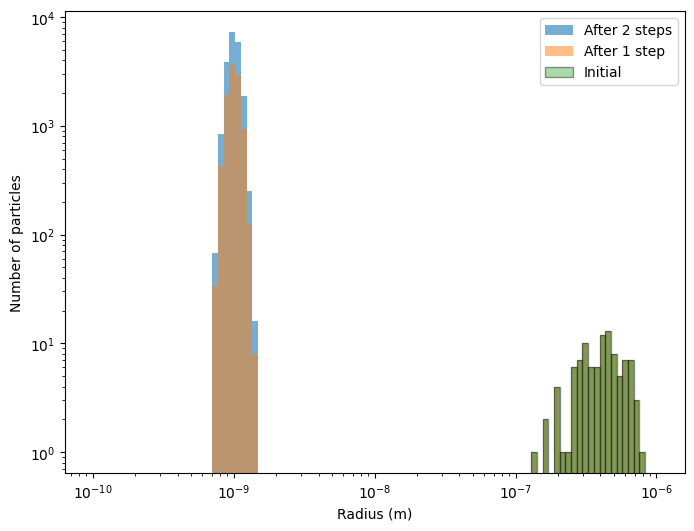

In [7]:
# Define lognormal bins for particle radius histogram
bins_lognormal = np.logspace(-10, -6, 100)

# Create figure for visualizing the histogram of particle radii
fig, ax = plt.subplots(figsize=(8, 6))

# Plot radii distribution after step 2
bins, edges = np.histogram(radii_after_step_2, bins=bins_lognormal)
ax.bar(
    edges[:-1],
    bins,
    width=np.diff(edges),
    align="edge",
    label="After 2 steps",
    alpha=0.6,
)
# Plot radii distribution after step 1

bins, edges = np.histogram(radii_after_step_1, bins=bins_lognormal)
ax.bar(
    edges[:-1],
    bins,
    width=np.diff(edges),
    align="edge",
    label="After 1 step",
    alpha=0.5,
)

# Plot initial radii distribution
bins, edges = np.histogram(initial_radii, bins=bins_lognormal)
ax.bar(
    edges[:-1],
    bins,
    width=np.diff(edges),
    align="edge",
    label="Initial",
    alpha=0.4,
    edgecolor="black")

# Set axes to logarithmic scale for x-axis (particle radius)
ax.set_xscale("log")
ax.set_yscale("log")

# Add labels and legend
ax.set_xlabel("Radius (m)")
ax.set_ylabel("Number of particles")
plt.legend()

# Show the plot
plt.show()

## Conclusion

We have demonstrated how to add particles to an aerosol object. This is useful when you want to modify a aerosol object with a custom process during a simulation.